In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 186 kB 50.7 MB/s 
     |████████████████████████████████| 1.2 MB 42.7 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 51 kB 328 kB/s 
Mounted at /content/gdrive


In [99]:
from fastbook import *

In [100]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
from pathlib import Path

In [43]:
#flowers = Path("/content/drive/MyDrive/dataset/flowers")

Para esta tarea, me apoye un poco de este tutorial: https://www.kaggle.com/kurianbenoy/image-classification-from-scratch-fastaiv2++}

In [101]:
# Download our data
path = untar_data(URLs.MNIST)

In [102]:
items= get_image_files(path)

In [103]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')
splits = splits(items)

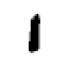

In [104]:
img = PILImageBW.create(items[0])
img.show()

In [105]:
dsrc = Datasets(items, tfms=[[PILImageBW.create],[parent_label, Categorize]],
                   splits=splits)

In [175]:
len(items)

70000

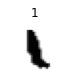

In [106]:
show_at(dsrc.train, 3)

In [107]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [108]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

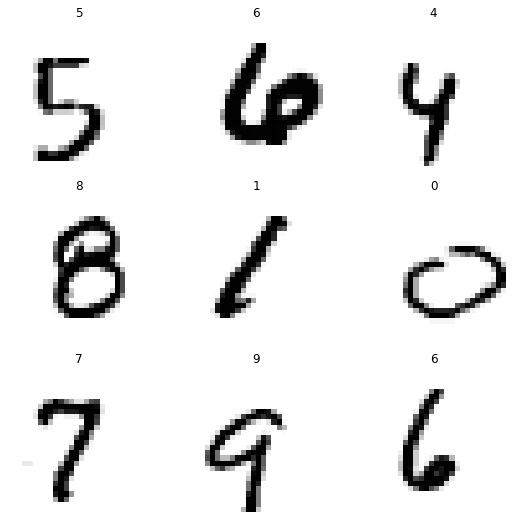

In [109]:
dls.show_batch()

In [110]:
# passing as a batch
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [111]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #return x.squeeze()
        return x.reshape(x.shape[0],-1)

def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [214]:
def get_model_1(trial=None):
  return nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
            nn.Conv2d(8,16, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(32,16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(16,10, kernel_size=3, stride=2, padding=1),
            Flatten() # and flatten it into a single dimention of predictions
            
)
  

In [215]:
learn = Learner(dls, get_model_1(), metrics=accuracy, opt_func=ranger)

SuggestedLRs(valley=0.0014454397605732083)

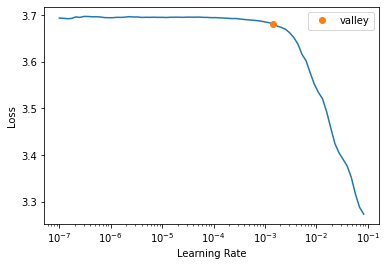

In [216]:
learn.lr_find()

In [217]:
learn.fit_one_cycle(5, lr_max=0.0014)

epoch,train_loss,valid_loss,accuracy,time
0,1.552283,0.877127,0.760600,02:08
1,1.380375,0.877026,0.756300,02:09
2,1.297928,0.823430,0.758000,02:08
3,1.270603,0.815450,0.771600,02:07
4,1.274571,0.818507,0.770200,02:08


# Usando optuna para encontrar mejores hiperparámetros

Optuna es un programa para optimizar hiperparámetros. Se puede instalar con _pip install optuna_

In [157]:
#!pip install optuna

In [218]:
import optuna

Debemos crear un "estudio" y después correrlo con una función objetivo 

In [219]:
study = optuna.create_study(direction='maximize')

[I 2021-09-07 22:24:10,191] A new study created in memory with name: no-name-ff978bf1-db18-4327-b528-2be24fe9fd5f


In [220]:
accuracy_index = learn.recorder.metric_names.index('accuracy')
learn.recorder.log[accuracy_index]

0.7702000141143799

In [221]:
def objective(trial):
    optimizer = trial.suggest_categorical('optimizer',["Ranger", "Adam"])
    opt_func = fv.ranger if optimizer == "Ranger" else fv.Adam
    learn = fv.Learner(dls, get_model_1(), metrics=fv.accuracy, opt_func=opt_func)
    learn.fit_one_cycle(trial.suggest_int('epochs',1,10), 
                        trial.suggest_float('lr',1e-6, 1e-1, log=True),
                       )
    
    accuracy_index = learn.recorder.metric_names.index('accuracy')
    return learn.recorder.log[accuracy_index]

In [222]:
study.optimize(objective, n_trials=5)

epoch,train_loss,valid_loss,accuracy,time
0,44.227840,1.438207,0.555700,02:12
1,1.545305,0.961008,0.688100,02:08
2,1.433917,0.999449,0.709100,02:07
3,1.265811,0.800093,0.773400,02:09


[I 2021-09-07 22:32:48,261] Trial 0 finished with value: 0.7734000086784363 and parameters: {'optimizer': 'Adam', 'epochs': 4, 'lr': 0.06756817088719072}. Best is trial 0 with value: 0.7734000086784363.


epoch,train_loss,valid_loss,accuracy,time
0,2.081888,1.458363,0.592000,02:08
1,1.490873,0.881141,0.760100,02:11
2,1.391099,0.857469,0.747200,02:10
3,1.355255,0.870211,0.748400,02:08
4,1.339403,0.850092,0.756600,02:09
5,1.316284,0.828880,0.766500,02:10
6,1.305288,0.831316,0.764600,02:13
7,1.303700,0.827582,0.768100,02:10
8,1.283095,0.817852,0.769800,02:09


[I 2021-09-07 22:52:21,168] Trial 1 finished with value: 0.7698000073432922 and parameters: {'optimizer': 'Adam', 'epochs': 9, 'lr': 0.0002951776634028145}. Best is trial 0 with value: 0.7734000086784363.


epoch,train_loss,valid_loss,accuracy,time
0,3.548852,1.033903,0.656700,02:09
1,1.341865,0.856858,0.754100,02:08


[I 2021-09-07 22:56:40,071] Trial 2 finished with value: 0.7541000247001648 and parameters: {'optimizer': 'Adam', 'epochs': 2, 'lr': 0.03999753312210693}. Best is trial 0 with value: 0.7734000086784363.


epoch,train_loss,valid_loss,accuracy,time
0,3.687283,3.683065,0.026800,02:12
1,3.550984,3.491432,0.121900,02:16
2,2.803929,2.678132,0.155300,02:16
3,2.409512,2.291137,0.288000,02:11
4,2.235638,2.093823,0.421400,02:13
5,2.152154,1.953831,0.501900,02:12
6,2.084766,1.849181,0.545200,02:18
7,2.065277,1.788520,0.556500,02:11
8,2.047894,1.764415,0.563000,02:13
9,2.038215,1.760854,0.563900,02:08


[I 2021-09-07 23:18:55,641] Trial 3 finished with value: 0.5638999938964844 and parameters: {'optimizer': 'Ranger', 'epochs': 10, 'lr': 2.2401939108795236e-05}. Best is trial 0 with value: 0.7734000086784363.


epoch,train_loss,valid_loss,accuracy,time
0,2.817675,2.383493,0.355200,02:07
1,1.618136,0.982827,0.722300,02:10
2,1.501743,0.890675,0.758600,02:11
3,1.476833,0.876249,0.765800,02:14
4,1.432682,0.835332,0.776700,02:15
5,1.426293,0.824264,0.782000,02:13
6,1.423878,0.823923,0.779600,02:10
7,1.408253,0.824735,0.779200,02:08
8,1.397292,0.822013,0.781100,02:10


[I 2021-09-07 23:38:38,643] Trial 4 finished with value: 0.7810999751091003 and parameters: {'optimizer': 'Adam', 'epochs': 9, 'lr': 0.00011068284405051291}. Best is trial 4 with value: 0.7810999751091003.


In [223]:
print(f"Los mejores parámetros son: {study.best_params}")

Los mejores parámetros son: {'optimizer': 'Adam', 'epochs': 9, 'lr': 0.00011068284405051291}


Probamos los parámetros obtenidos con Optuna

In [231]:
learn_optuna = Learner(dls, get_model_1(), metrics=accuracy, opt_func=ranger)

In [232]:
study.best_params

{'epochs': 9, 'lr': 0.00011068284405051291, 'optimizer': 'Adam'}

In [233]:
learn_optuna.fit_one_cycle(study.best_params["epochs"], lr_max=study.best_params["lr"])

epoch,train_loss,valid_loss,accuracy,time
0,3.500673,3.295348,0.175200,02:11
1,1.910697,1.315127,0.633300,02:13
2,1.602038,0.967356,0.733500,02:16
3,1.542683,0.907282,0.757000,02:15
4,1.503028,0.886831,0.755700,02:17
5,1.472456,0.867018,0.761600,02:17
6,1.458656,0.863178,0.762600,02:16
7,1.479999,0.859965,0.767800,02:16
8,1.469783,0.860438,0.765200,02:19
